In [62]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)

2.3.1


In [620]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [79]:
print(dataset)
print(dataset_dir)

./aclImdb_v1.tar.gz
./aclImdb


In [67]:
os.listdir(dataset_dir)

['test', 'README', 'imdb.vocab', 'imdbEr.txt', 'train']

In [82]:
! ls ./aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [87]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'unsupBow.feat',
 'neg',
 'pos',
 'urls_unsup.txt',
 'urls_neg.txt',
 'urls_pos.txt']

In [85]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [95]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [Errno 2] No such file or directory: './aclImdb/train/unsup'

In [621]:
batch_size = 8
seed = 42

imdb_reviews = 'aclImdb/train'
imdb_reviews_test = 'aclImdb/test'

medical_notes_dir = '/home/muody/data/medicalnotes/dataset/train-data'
medical_notes_dir_test = '/home/muody/data/medicalnotes/dataset/unlabeled-test-data'

raw_data = imdb_reviews
test_data = imdb_reviews_test

raw_data = medical_notes_dir
test_data = medical_notes_dir


raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    raw_data, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 826 files belonging to 5 classes.
Using 661 files for training.


In [622]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B> Colovesical fistula.\n\n<B>POSTOPERATIVE DIAGNOSES:</B>\n1.  Colovesical fistula.\n2.  Intraperitoneal abscess.\n\n<B>PROCEDURE PERFORMED:</B>\n1.  Exploratory laparotomy.\n2.  Low anterior colon resection.\n3.  Flexible colonoscopy.\n4.  Transverse loop colostomy and JP placement.\n\n<B>ANESTHESIA: </B> General.\n\n<B>HISTORY:  </B>This 74-year-old female who had a recent hip fracture and the patient was in rehab when she started having some stool coming out of the urethra.  The patient had retrograde cystogram, which revealed colovesical fistula.  Recommendation for a surgery was made.  The patient was explained the risks and benefits as well as the two sons and the daughter.  They understood that the patient can even die from this procedure.  All the three procedures were explained, without a colostomy, with Hartmann's colostomy, and with a transverse loop colostomy, and out of the three procedures, the patient's requested to have t

In [623]:
for i in range(len(raw_train_ds.class_names)):
    print("Label {} corresponds to".format(i), raw_train_ds.class_names[i])

Label 0 corresponds to Gastroenterology
Label 1 corresponds to Neurology
Label 2 corresponds to Orthopedic
Label 3 corresponds to Radiology
Label 4 corresponds to Urology


In [624]:
# VALIDATION
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    raw_data, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 826 files belonging to 5 classes.
Using 165 files for validation.


In [625]:
# TEST
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_data, 
    batch_size=batch_size)

Found 826 files belonging to 5 classes.


In [626]:
# remove html tags
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '\n', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '</B>', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '<B>', ' ')
    stripped_html = tf.strings.unicode_transcode(stripped_html, "UTF-8", "UTF-8")
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [603]:
max_features = 100000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [604]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [605]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [606]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'\n\n\n\n\n<B>CC:</B> Sudden onset blindness.\n\n<B>HX:</B> This 58 y/o RHF was in her usual healthy state, until 4:00PM, 1/8/93, when she suddenly became blind. Tongue numbness and slurred speech occurred simultaneously with the loss of vision. The vision transiently improved to &quot;severe blurring&quot; enroute to a local ER, but worsened again once there. While being evaluated she became unresponsive, even to deep noxious stimuli. She was transferred to UIHC for further evaluation. Upon arrival at UIHC her signs and symptoms were present but markedly improved.\n\n<B>PMH:</B> 1) Hysterectomy many years previous. 2) Herniorrhaphy in past. 3) DJD, relieved with NSAIDs.\n\n<B>FHX/SHX:</B> Married x 27yrs. Husband denied Tobacco/ETOH/illicit drug use for her.\n\nUnremarkable FHx.\n\n<B>MEDS:</B> none.\n\n<B>EXAM:</B> Vitals: 36.9C.  HR 93.  BP 151/93.  RR 22.  98% O2Sat.\n\nMS: somnolent, but arousable to verbal stimulation. minimal speech. followed simple commands on

In [607]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[163])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[193])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  bpreoperative
 313 --->  condition
Vocabulary size: 15475


In [608]:
# testing replace
eagertensor = tf.strings.regex_replace("\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B>","</B>", "")
result = eagertensor.numpy()
result.decode('utf-8')

'\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: '

In [637]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [638]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [657]:
embedding_dim = 64

In [658]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5)])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 64)          6400064   
_________________________________________________________________
dropout_28 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
global_average_pooling1d_14  (None, 64)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 325       
Total params: 6,400,389
Trainable params: 6,400,389
Non-trainable params: 0
_________________________________________________________________


In [660]:
loss = losses.SparseCategoricalCrossentropy()
#loss = losses.BinaryCrossentropy
#losses.BinaryCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer='adam',
              metrics='accuracy')

In [661]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
83/83 [==============================] - 4s 53ms/step - loss: 2.2174 - accuracy: 0.4811 - val_loss: 1.1209 - val_accuracy: 0.6242
Epoch 2/10
83/83 [==============================] - 3s 40ms/step - loss: 0.8072 - accuracy: 0.7504 - val_loss: 1.4092 - val_accuracy: 0.7152
Epoch 3/10
83/83 [==============================] - 4s 45ms/step - loss: 0.8031 - accuracy: 0.7912 - val_loss: 1.6686 - val_accuracy: 0.7030
Epoch 4/10
83/83 [==============================] - 4s 44ms/step - loss: 0.6129 - accuracy: 0.8079 - val_loss: 1.9723 - val_accuracy: 0.6545
Epoch 5/10
83/83 [==============================] - 4s 45ms/step - loss: 0.6237 - accuracy: 0.8366 - val_loss: 1.9920 - val_accuracy: 0.6788
Epoch 6/10
83/83 [==============================] - 4s 45ms/step - loss: 0.6144 - accuracy: 0.8396 - val_loss: 2.5268 - val_accuracy: 0.6364
Epoch 7/10
83/83 [==============================] - 4s 45ms/step - loss: 1.0444 - accuracy: 0.7413 - val_loss: 1.7860 - val_accuracy: 0.5515
Epoch 8/10
83

In [662]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

104/104 [==============================] - 0s 1ms/step - loss: 0.6536 - accuracy: 0.8414
Loss:  0.6536284685134888
Accuracy:  0.841404378414154


In [663]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

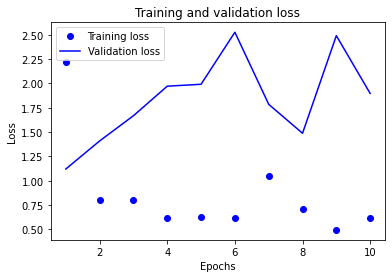

In [664]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

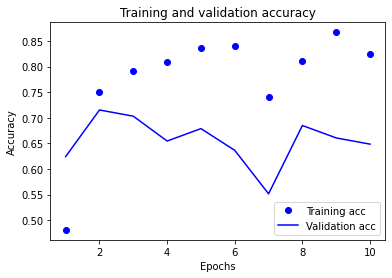

In [665]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()